In [1]:
from datetime import datetime, timedelta
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import app

def get_data(path: str, start: int, end: int, clip: int = 15):
    """Read data files based on date offset start and end."""
    t0 = datetime.now() - timedelta(days=start + 1)
    t1 = datetime.now() - timedelta(days=end)
    df = pd.DataFrame([])
    for file in sorted(Path(path).glob("*.json")):
        date = datetime.strptime(file.stem.split("_")[0], "%Y-%m-%d")
        if date >= t0 and date < t1:
            df = pd.concat([df, pd.read_json(file)], axis=0)
    return app.clip_data(df, clip)

In [2]:
models = {}
models["dense"] = app.get_multidense_model
models["cnn"] = app.get_convolution_model
models["lstm"] = app.get_lstm_model
# select
data = "metrics/relax"
days = 14
steps = 96
df = get_data(data, days, 0, clip=15)
df

,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime
0,0.035200,0.023500,0.575200,9.072130,2.108697,4.983155
1,0.022700,0.019800,0.719100,7.371115,2.209397,5.776501
2,0.012100,0.014000,1.395299,6.346526,2.495195,6.021573
3,0.052700,0.067000,2.188497,6.194649,2.982094,6.156155
4,0.055100,0.074200,5.199745,5.564720,3.454789,6.631669
...,...,...,...,...,...,...
1243,11.491501,13.054570,1.732999,1.027300,0.059900,11.985487
1244,13.995268,12.946507,2.267797,0.407500,0.263900,10.525341
1245,13.247283,13.896480,2.809996,0.104400,0.426800,11.094071
1246,11.151556,10.267953,2.823195,0.037700,0.485800,9.347285


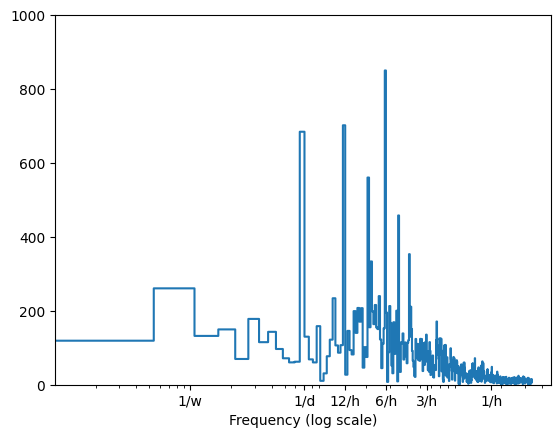

In [3]:
fft = tf.signal.rfft(df[df.columns[-1]])
f_per_dataset = np.arange(0, len(fft))

n_samples_15min = df.shape[0]
n_15min_per_week = 96 * 7
weeks_per_dataset = n_samples_15min/n_15min_per_week

f_per_week = f_per_dataset/weeks_per_dataset
plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 1000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 7, 7 * 2, 7 * 4, 7 * 8, 7 * 24], labels=['1/w', '1/d', '12/h', '6/h', '3/h', '1/h'])
_ = plt.xlabel('Frequency (log scale)')

,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime,1-hour_sin,1-hour_cos,3-hour_sin,3-hour_cos,6-hour_sin,6-hour_cos,12-hour_sin,12-hour_cos,24-hour_sin,24-hour_cos,1-week_sin,1-week_cos
0,0.035200,0.023500,0.575200,9.072130,2.108697,4.983155,0.000000e+00,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.022700,0.019800,0.719100,7.371115,2.209397,5.776501,1.000000e+00,6.123234e-17,0.500000,8.660254e-01,0.258819,0.965926,0.130526,0.991445,0.065403,0.997859,0.009350,0.999956
2,0.012100,0.014000,1.395299,6.346526,2.495195,6.021573,1.224647e-16,-1.000000e+00,0.866025,5.000000e-01,0.500000,0.866025,0.258819,0.965926,0.130526,0.991445,0.018699,0.999825
3,0.052700,0.067000,2.188497,6.194649,2.982094,6.156155,-1.000000e+00,-1.836970e-16,1.000000,6.123234e-17,0.707107,0.707107,0.382683,0.923880,0.195090,0.980785,0.028046,0.999607
4,0.055100,0.074200,5.199745,5.564720,3.454789,6.631669,-2.449294e-16,1.000000e+00,0.866025,-5.000000e-01,0.866025,0.500000,0.500000,0.866025,0.258819,0.965926,0.037391,0.999301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,11.491501,13.054570,1.732999,1.027300,0.059900,11.985487,-1.000000e+00,4.852511e-14,-0.500000,-8.660254e-01,-0.965926,0.258819,-0.608761,0.793353,-0.321439,0.946930,-0.810115,0.586271
1244,13.995268,12.946507,2.267797,0.407500,0.263900,10.525341,-1.370862e-14,1.000000e+00,-0.866025,-5.000000e-01,-0.866025,0.500000,-0.500000,0.866025,-0.258819,0.965926,-0.804598,0.593820
1245,13.247283,13.896480,2.809996,0.104400,0.426800,11.094071,1.000000e+00,-3.774450e-14,-1.000000,-6.366306e-15,-0.707107,0.707107,-0.382683,0.923880,-0.195090,0.980785,-0.799010,0.601317
1246,11.151556,10.267953,2.823195,0.037700,0.485800,9.347285,2.448922e-14,-1.000000e+00,-0.866025,5.000000e-01,-0.500000,0.866025,-0.258819,0.965926,-0.130526,0.991445,-0.793353,0.608761


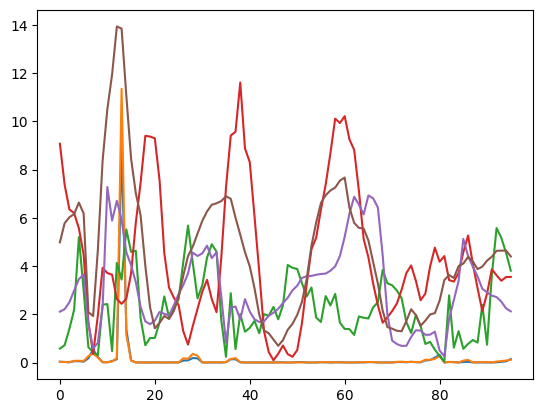

In [4]:
df = app.add_time_features(df)
plt.plot(df[df.columns[0:6]].iloc[0:96])
df

In [5]:
# walk forward cross validation (circular)
def generate_sliding_window(population_size: int, sample_size=96, cycles=3, step_size=2):
    X = np.tile(np.arange(0, population_size, 1), 2) # circular?
    test_size = val_size = sample_size
    train_size = population_size - ((test_size + val_size) * cycles)
    for step in range(0, cycles):
        train_left = (sample_size * step)
        train_right = train_left + (train_size)
        val_right = train_right + (val_size * step_size)
        test_right = val_right + (test_size * step_size)
        yield X[train_left:train_right], X[train_right:val_right], X[val_right:test_right]

for train, val, test in generate_sliding_window(df.shape[0]):
    print(train.shape, val.shape, test.shape)
    print(train[0], val[0], test[0])

(672,) (192,) (192,)
0 672 864
(672,) (192,) (192,)
96 768 960
(672,) (192,) (192,)
192 864 1056


[
  {
    "val": 0.2537950575351715,
    "test": 0.27793705463409424
  },
  {
    "val": 0.2325756996870041,
    "test": 0.3270566761493683
  },
  {
    "val": 0.26258477568626404,
    "test": 0.7264209389686584
  }
]
0.2496518443028132
0.44380488991737366


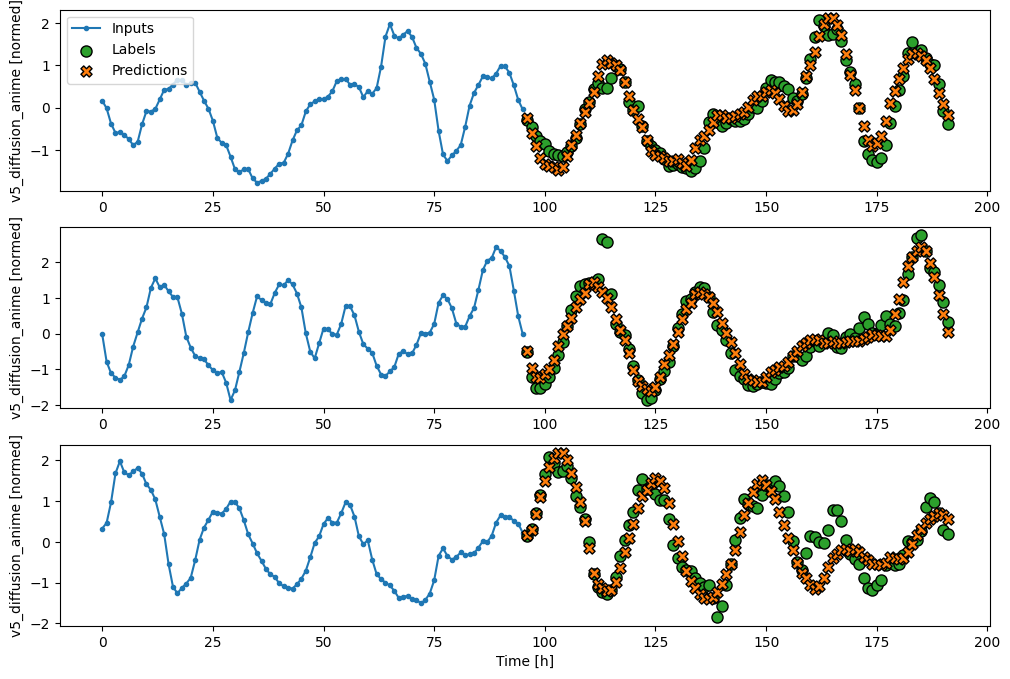

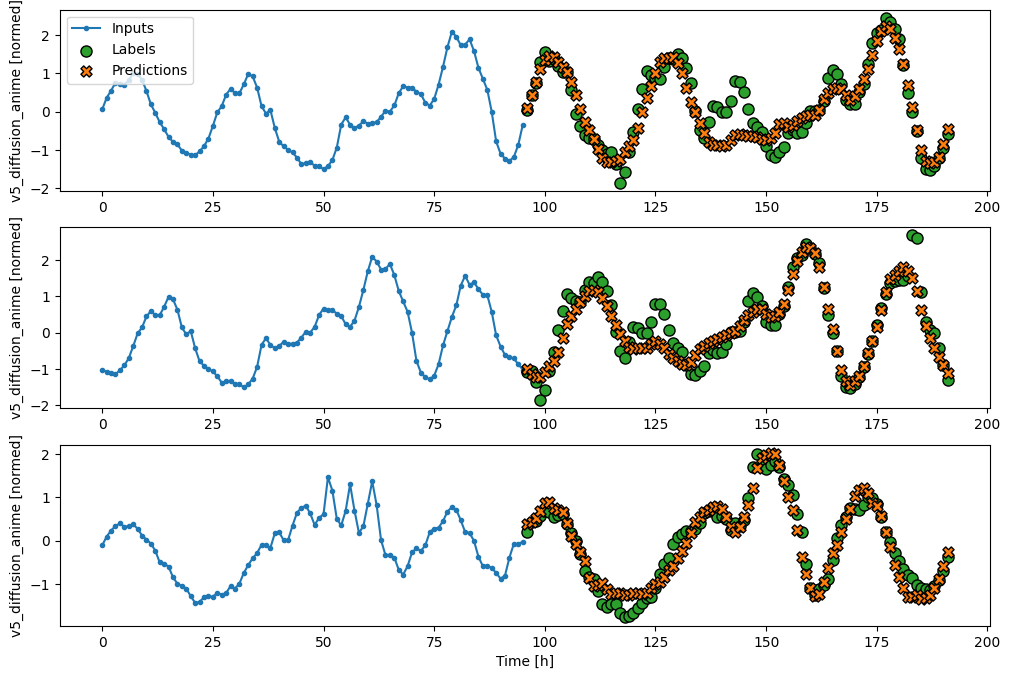

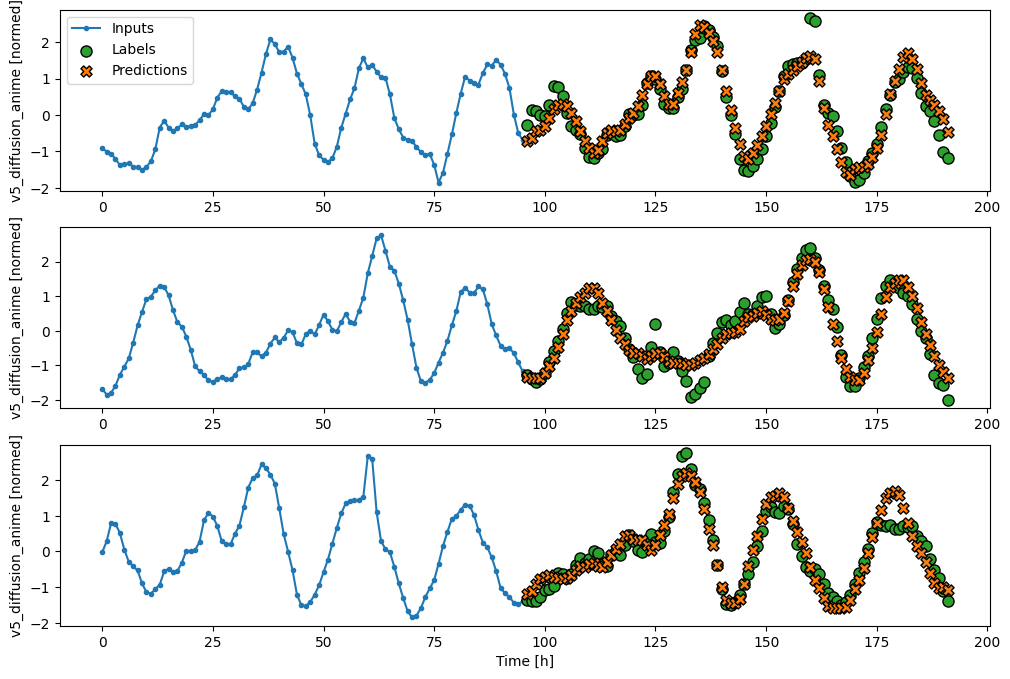

In [6]:
selected = "dense"
model: app.Model = models[selected](df.shape[1], steps)
perf = []
windows = []
for train, val, test in generate_sliding_window(population_size=df.shape[0]):
    train_df, val_df, test_df, std, mean = app.normalize_training_data(
        df.iloc[train], df.iloc[val], df.iloc[test]
    )
    window = app.WindowGenerator(
        train_df, val_df, test_df, input_width=steps, label_width=steps, shift=steps
    )
    app.compile_and_fit(model, window, patience=4, max_epocs=40)
    perf.append({"val": model.evaluate(window.val, verbose=0)[1], "test": model.evaluate(window.test, verbose=0)[1]})
    windows.append({"window": window, "model": model})
# output
print(json.dumps(perf, indent=2))
print(sum(p["val"] for p in perf) / len(perf))
print(sum(p["test"] for p in perf) / len(perf))
for win in windows:
    win["window"].plot(model=win["model"], plot_col=df.columns[5])
model.save(f"model.h5")

1/1 [==============================] - 0s 160ms/step
(1, 96, 18)


,kdpt_diffusion_anime,v4_anime_upscaler,v4_diffusion,v4_upscaler,v5_diffusion,v5_diffusion_anime
0,2.188876,1.152696,0.000000,2.870779,2.780096,7.691077
1,0.433529,0.424381,0.756973,10.426980,5.688103,8.203954
2,0.234073,0.387370,5.018930,12.361557,6.487731,11.561995
3,0.047128,0.139201,7.573515,12.691590,7.609610,15.000000
4,0.678542,0.478787,6.963670,13.785157,7.091605,15.000000
...,...,...,...,...,...,...
91,0.226275,0.114289,2.837248,0.000000,0.000000,1.661225
92,0.219943,0.130562,1.467201,0.840195,0.214162,5.227029
93,0.095625,0.000000,3.713229,0.000000,1.890926,6.749884
94,0.000000,0.000000,2.498402,0.000000,2.245306,6.331902


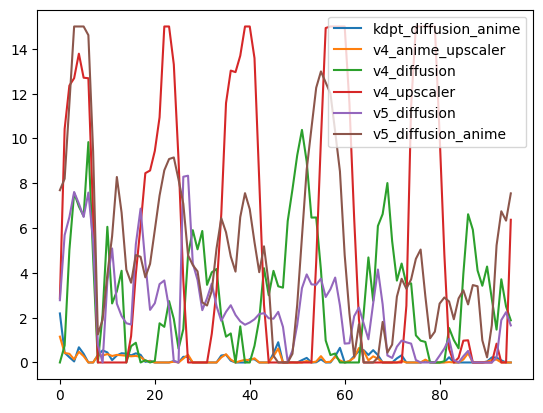

In [7]:
model = app.load_model(f"model.h5")
y_pred = model.predict(app.get_predict_window_dataset((app.add_time_features(get_data(data, 1, 0)) - mean) / std))
print(y_pred.shape)
y = y_pred[0, :, 0:6] * std[0:6].values + mean[0:6].values
y = np.clip(y, 0, 15)
y_df = pd.DataFrame(y, columns=df.columns[0:6])
plt.plot(y)
plt.legend(y_df.columns[0:6])
y_df